In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.cloud import bigquery
client = bigquery.Client(project='stackoverflow-372313')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud

<h2>1. Total number of records in posts_questions table:</h2>

In [4]:
query = ('''SELECT COUNT(*) AS ques_cnt FROM `bigquery-public-data.stackoverflow.posts_questions`''')
df = client.query(query).to_dataframe()
df

,ques_cnt
0,23020127


It has a total of 23020127(~23 million) records.

<h2>2. Total number of records in posts_answers table:</h2>

In [5]:
query = ('''SELECT COUNT(id) AS ans_cnt FROM `bigquery-public-data.stackoverflow.posts_answers`''')
df = client.query(query).to_dataframe()
df

,ans_cnt
0,34024119


It has a total of 34024119(~34 million) records.

<h2>3. Number of unanswered questions:</h2>

In [6]:
query = ('''SELECT COUNT(id) AS unanswered_ques_count FROM `bigquery-public-data.stackoverflow.posts_questions`
            WHERE id NOT IN (SELECT parent_id FROM `bigquery-public-data.stackoverflow.posts_answers`)''')
df = client.query(query).to_dataframe()
df

,unanswered_ques_count
0,3316808


These are the questions which have not received any answers. For a search engine it does not make sense to show similar questions which do not have any answer so we can simply discard those questions from our data. We will remove a total of 3316808(~3 million) questions from the data.

<h2>4. Question Title Text Analysis:</h2>

In [7]:
query = ('''SELECT title FROM `bigquery-public-data.stackoverflow.posts_questions`''')
df = client.query(query).to_dataframe()
df.head(10)

,title
0,How can I accurately set the new cursor positi...
1,Can't edit files in a laravel project due to f...
2,Firebase snapShot value order changed after co...
3,Keep hitting !DISABLE_XAML_GENERATED_BREAK_ON_...
4,"python, mongoengine ReferenceField duplicate k..."
5,How to write GC log to named pipe in Java 9?
6,Failed to connect to : Connection refused - cU...
7,Customize contact form in HR module- Odoo v10
8,Reactjs showing markdown in html
9,Setting replication factor in Network Topology


<h3>4.1 Distribution of word count in question title:</h3>

In [8]:
query = ('''WITH all_words_arr AS 
            (
              SELECT id, SPLIT(title, ' ') as word_arr 
              FROM `bigquery-public-data.stackoverflow.posts_questions`
            ),
            all_words AS 
            (
              SELECT id, words 
              FROM all_words_arr
              CROSS JOIN UNNEST(all_words_arr.word_arr) AS words
            ),
            title_word_count AS
            (
              SELECT id, COUNT(*) AS word_count 
              FROM all_words GROUP BY id ORDER BY word_count DESC
            )
            SELECT word_count, COUNT(*) AS no_of_ques FROM title_word_count GROUP BY word_count ORDER BY word_count''')
df = client.query(query).to_dataframe()
df.head(10)

,word_count,no_of_ques
0,1,4277
1,2,88988
2,3,556211
3,4,1296565
4,5,1987742
5,6,2489459
6,7,2718001
7,8,2687961
8,9,2440074
9,10,2086505


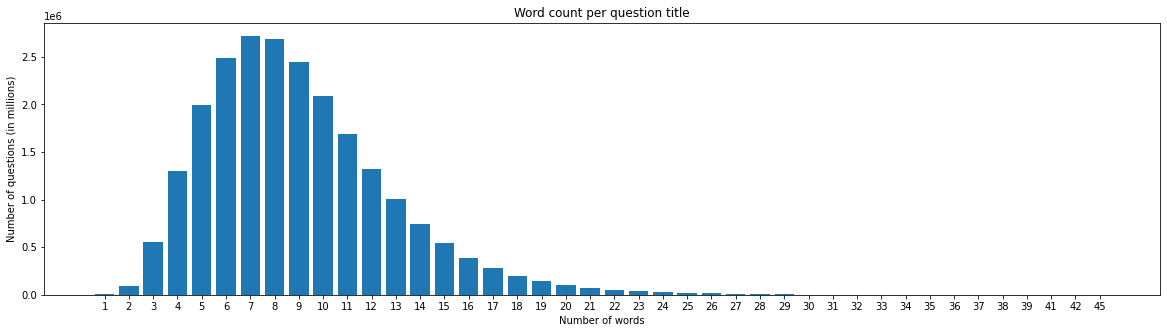

In [9]:
word_count = list(df['word_count'].values)
no_of_ques = list(df['no_of_ques'].values)
ind = np.arange(len(word_count))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, no_of_ques)

plt.xlabel('Number of words')
plt.ylabel('Number of questions (in millions)')
plt.title('Word count per question title')
plt.xticks(ind, list(word_count))
plt.show()

**Observations:**
1. Most questions have 5-10 words in the title.<br>
2. Very few questions have title with less than 3 or more than 15 words.

In [10]:
query = ('''WITH all_words_arr AS 
            (
              SELECT id, SPLIT(title, ' ') as word_arr 
              FROM `bigquery-public-data.stackoverflow.posts_questions`
            ),
            all_words AS 
            (
              SELECT id, words 
              FROM all_words_arr
              CROSS JOIN UNNEST(all_words_arr.word_arr) AS words
            ),
            title_word_count AS
            (
              SELECT id, COUNT(*) AS word_count 
              FROM all_words GROUP BY id ORDER BY word_count DESC
            )
            SELECT * FROM title_word_count''')
df = client.query(query).to_dataframe()
df.head(10)

,id,word_count
0,50441974,8
1,50464983,8
2,50382519,8
3,50321171,8
4,50471870,8
5,51052556,8
6,51086334,8
7,51023791,8
8,50691481,8
9,50924254,8


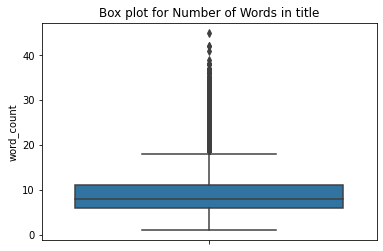

In [11]:
sns.boxplot(y='word_count', data=df)
plt.title("Box plot for Number of Words in title")
plt.show()

**Observations:**
1. 25% of questions have 6 words in title.<br>
2. 50% of questions have 8 words in title.<br>
3. 75% of questions have 11 words in title.

<h3>4.2 Percentile distribution word count in question title:

In [12]:
var = sorted(df.word_count)
for i in [10,20,30,40,50,60,70,80,90]:
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

10 percentile value is 5
20 percentile value is 6
30 percentile value is 7
40 percentile value is 8
50 percentile value is 8
60 percentile value is 9
70 percentile value is 10
80 percentile value is 12
90 percentile value is 14
100 percentile value is  45


In [13]:

for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 14
91 percentile value is 14
92 percentile value is 15
93 percentile value is 15
94 percentile value is 15
95 percentile value is 16
96 percentile value is 17
97 percentile value is 18
98 percentile value is 19
99 percentile value is 21
100 percentile value is  45


**Observations:**
1. 90% of questions have 14 words in the title.<br>
2. While 99% of questions have 19 words in the title.<br>
3. Just 1% of questions have more than 21 words in the title so we can keep 21 words as cutoff for question title which will cover more than 99% of questions.

<h2>5. Question Body Text Analysis:</h2>

In [14]:
query = ('''select body from `bigquery-public-data.stackoverflow.posts_questions` LIMIT 10''')
df = client.query(query).to_dataframe()

In [15]:
df.iloc[0].body

'<p>how can i send 3 text box,1 select button value in a form by using <code>&lt;a href=&gt;</code> tag,to another page?</p>'

<h3>5.1 Percentile distribution word count in question body:</h3>

In [17]:
query = ('''WITH all_words_arr AS 
            (
              SELECT id, SPLIT(body, ' ') as word_arr 
              FROM `bigquery-public-data.stackoverflow.posts_questions`
            ),
            all_words AS 
            (
              SELECT id, words 
              FROM all_words_arr
              CROSS JOIN UNNEST(all_words_arr.word_arr) AS words
            ),
            body_word_count AS
            (
              SELECT id, COUNT(*) AS word_count 
              FROM all_words GROUP BY id ORDER BY word_count
            )
            SELECT * FROM body_word_count''')
df = client.query(query).to_dataframe()
df.head(10)

,id,word_count
0,2427002,4
1,13439080,4
2,981569,5
3,31746695,5
4,4277297,5
5,34334952,5
6,62752128,5
7,2286799,5
8,72559950,5
9,69961541,5


In [7]:
var = sorted(df.word_count)
for i in [10,20,30,40,50,60,70,80,90]:
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

10 percentile value is 47
20 percentile value is 67
30 percentile value is 88
40 percentile value is 112
50 percentile value is 142
60 percentile value is 182
70 percentile value is 242
80 percentile value is 343
90 percentile value is 572
100 percentile value is  59940


In [8]:
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 572
91 percentile value is 615
92 percentile value is 665
93 percentile value is 725
94 percentile value is 799
95 percentile value is 894
96 percentile value is 1022
97 percentile value is 1207
98 percentile value is 1512
99 percentile value is 2168
100 percentile value is  59940


In [10]:
ran=[99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9]
for i in ran:
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

99.1 percentile value is 2285
99.2 percentile value is 2420
99.3 percentile value is 2580
99.4 percentile value is 2773
99.5 percentile value is 3018
99.6 percentile value is 3342
99.7 percentile value is 3788
99.8 percentile value is 4480
99.9 percentile value is 5826
100 percentile value is  59940


**Observations:**
1. 90% of questions have 572 words in the body.<br>
2. While 99% of questions have 2168 words in the body.<br>
3. Just 1% of questions have more than 2168 words in the body.<br>
Since around 99% questions' body have less than or equal to 2000 words we will consider that as cut off for better understanding of word count distribution.

In [18]:
df=df[df.word_count<=2000]
df.tail()

,id,word_count
23018758,9330891,1999
23018759,6745867,2000
23018760,64380098,2000
23018761,57751583,2000
23018762,24945534,2000


<h3>5.2 Distribution of word count in question BODY:</h3>

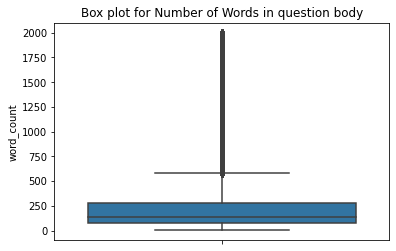

In [19]:
sns.boxplot(y='word_count', data=df)
plt.title("Box plot for Number of Words in question body")
plt.show()

**Observations:**
1. 25% of questions have around 75 words in the body.<br>
2. 50% of questions have around 150 words in the body.<br>
3. 75% of questions have around 300 words in the body.

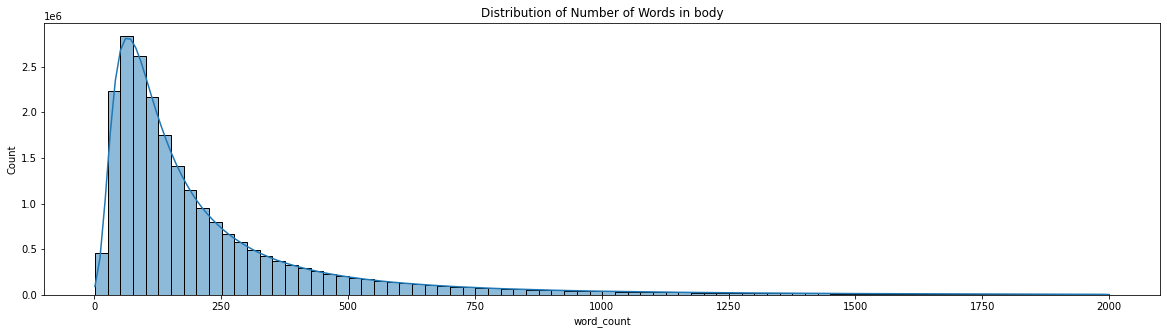

In [19]:
plt.figure(figsize=(20,5))
plt.ylabel('Number of questions (in millions)')
plt.xlabel('Number of words')
plt.title("Distribution of Number of Words in body")
sns.histplot(data=df, x='word_count', binwidth=25, kde=True)
#s.set_xlim(1, 2000)

**Observations:**
1. Majority of questions (almost 80%) have 25-300 words in the body.<br>
2. Very few questions (around 10%) have more than 500 words in the body.

<h2>6. Number of answers per question:</h2>

In [26]:
query = ('''SELECT COUNT(parent_id) AS no_of_ans 
            FROM `bigquery-public-data.stackoverflow.posts_answers`
            GROUP BY parent_id ORDER BY no_of_ans''')
df = client.query(query).to_dataframe()

<h3>6.1 Percentile Distribution of Number of answers per question:</h3>

In [27]:
var = sorted(df.no_of_ans)
for i in [10,20,30,40,50,60,70,80,90]:
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

10 percentile value is 1
20 percentile value is 1
30 percentile value is 1
40 percentile value is 1
50 percentile value is 1
60 percentile value is 2
70 percentile value is 2
80 percentile value is 2
90 percentile value is 3
100 percentile value is  518


In [28]:
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 3
91 percentile value is 3
92 percentile value is 3
93 percentile value is 3
94 percentile value is 4
95 percentile value is 4
96 percentile value is 4
97 percentile value is 5
98 percentile value is 5
99 percentile value is 7
100 percentile value is  518


**Observations:**
1. 90% of questions have a maximum of 3 answers.<br>
2. While 99% of questions a maximum of 7 answers.<br>
3. Just 1% of questions have more than 7 answers.

<h3>6.2 Distribution of Number of answers per question:</h3>

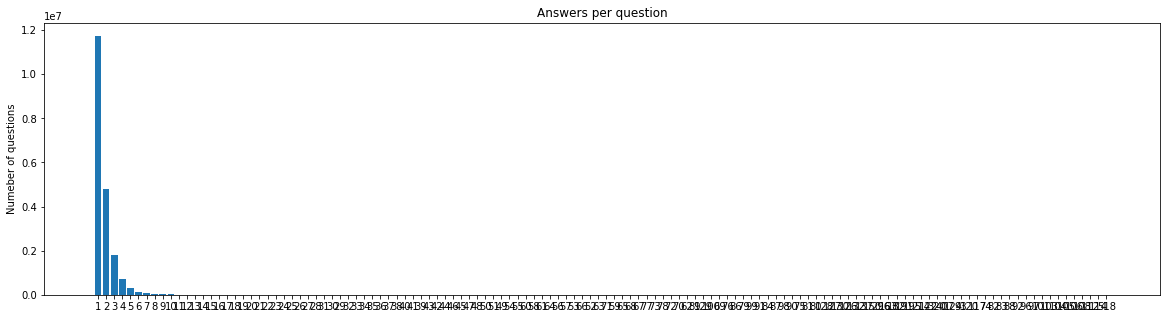

In [30]:
ans_count = dict(df['no_of_ans'].values.value_counts())
ind = np.arange(len(ans_count))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(ans_count.values()))

plt.ylabel('Numeber of questions')
plt.title('Answers per question')
plt.xticks(ind, list(ans_count.keys()))
plt.show()

Since very few questions have more than 10 answers we will see distribution of number of questions with a maximum of 10 answers.

In [31]:
df=df[df.no_of_ans<=10]

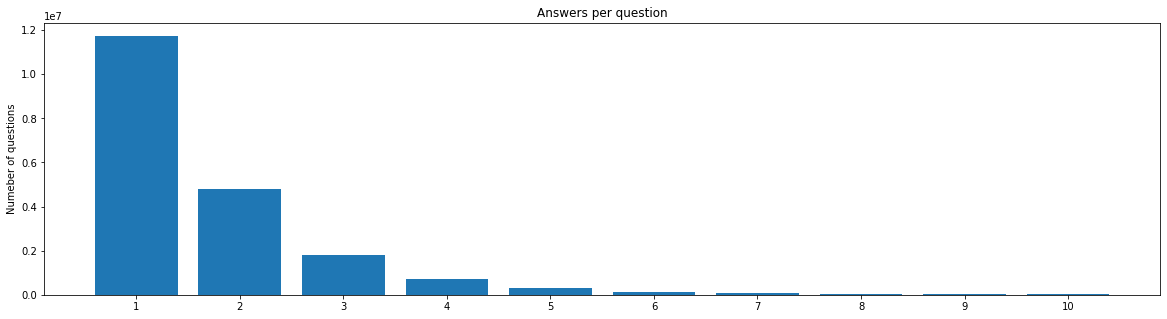

In [32]:
ans_count = dict(df['no_of_ans'].values.value_counts())
#ans_count_10 = dict(ans_count[0:10])
ind = np.arange(len(ans_count))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(ans_count.values()))

plt.ylabel('Numeber of questions')
plt.title('Answers per question')
plt.xticks(ind, list(ans_count.keys()))
plt.show()

**Observations:**
1. Majority of questions (almost 95%) have less than 5 answers.<br>
2. Very few questions (around 1%) have 7 or more answers.

<h2>7. Answer Body Text Analysis:</h2>

In [33]:
query = ('''WITH all_words_arr AS 
            (
              SELECT id, SPLIT(body, ' ') as word_arr 
              FROM `bigquery-public-data.stackoverflow.posts_answers`
            ),
            all_words AS 
            (
              SELECT id, words 
              FROM all_words_arr
              CROSS JOIN UNNEST(all_words_arr.word_arr) AS words
            ),
            body_word_count AS
            (
              SELECT id, COUNT(*) AS word_count 
              FROM all_words GROUP BY id ORDER BY word_count
            )
            SELECT * FROM body_word_count''')
df = client.query(query).to_dataframe()
df.head(10)

,id,word_count
0,19830090,1
1,30679979,1
2,3578833,1
3,37292132,1
4,63210358,1
5,5112064,1
6,40587279,1
7,1395137,1
8,6942116,1
9,2440363,1


<h3>7.1 Percentile distribution word count in answer body:

In [34]:
var = sorted(df.word_count)
for i in [10,20,30,40,50,60,70,80,90]:
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

10 percentile value is 20
20 percentile value is 30
30 percentile value is 42
40 percentile value is 54
50 percentile value is 70
60 percentile value is 90
70 percentile value is 119
80 percentile value is 166
90 percentile value is 267
100 percentile value is  46338


In [35]:
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 267
91 percentile value is 286
92 percentile value is 307
93 percentile value is 333
94 percentile value is 364
95 percentile value is 404
96 percentile value is 458
97 percentile value is 535
98 percentile value is 661
99 percentile value is 936
100 percentile value is  46338


In [34]:
ran=[99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9]
for i in ran:
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

99.1 percentile value is 985
99.2 percentile value is 1043
99.3 percentile value is 1113
99.4 percentile value is 1197
99.5 percentile value is 1305
99.6 percentile value is 1450
99.7 percentile value is 1658
99.8 percentile value is 1994
99.9 percentile value is 2717
100 percentile value is  46338


**Observations:**
1. 90% of answers have less than or equal to 267 words in the body.<br>
2. While 99% of answers have less than or equal to 936 words in the body.<br>
Since around 99% questions' body have less than or equal to 900 words we will consider that as cut off for better understanding of word count distribution.


In [35]:
df=df[df.word_count<=900]
df.tail()

,id,word_count
34022355,25342953,899
34022356,41184729,899
34022357,52457357,900
34022358,72424382,900
34022359,41814981,900


<h3>7.2 Distribution of word count in answer body:</h3>

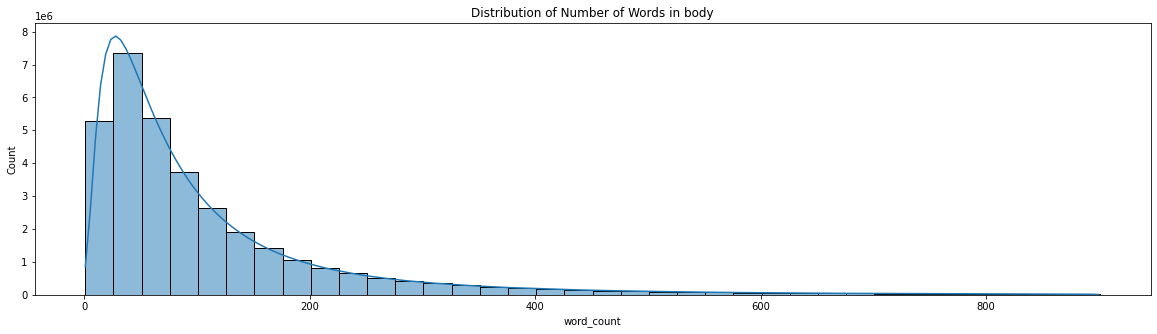

In [36]:
plt.figure(figsize=(20,5))
plt.title("Distribution of Number of Words in body")
sns.histplot(data=df, x='word_count', binwidth=25, kde=True)

**Observations:**
1. Majority of answers (almost 80%) have 25-200 words in the body.<br>
2. Very few answers (around 5%) have more than 400 words in the body.

<h2>8. Analysis of tags:</h2>

In [ ]:
query = ('''WITH 
            ques_with_answer AS 
            (
              SELECT * FROM `bigquery-public-data.stackoverflow.posts_questions`
              WHERE id IN 
                        (
                          SELECT DISTINCT(parent_id) FROM `bigquery-public-data.stackoverflow.posts_answers`
                        )
            ),
            ques_tags AS
            (
              SELECT id, tags FROM ques_with_answer
            ),
            all_tags_conn AS 
            (
              SELECT id, SPLIT(tags, '|') as tag FROM ques_tags
            ),
            all_tags AS 
            (
              SELECT id, flattened_tags 
              FROM all_tags_conn
              CROSS JOIN UNNEST(all_tags_conn.tag) AS flattened_tags
            )
            SELECT COUNT(DISTINCT(flattened_tags)) AS total_tag_count FROM all_tags''')
df = client.query(query).to_dataframe()
df

,total_tag_count
0,62783


There are a total of 62783 unique tags attached with the questions which have at least an answer.

There are many tags which are very rarely used so we will considered tags which are used at least 100 times.

In [37]:
query = ('''WITH 
            ques_with_answer AS 
            (
              SELECT * FROM `bigquery-public-data.stackoverflow.posts_questions`
              WHERE id IN 
                        (
                          SELECT DISTINCT(parent_id) FROM `bigquery-public-data.stackoverflow.posts_answers`
                          )
            ),
            ques_tags AS
            (
              SELECT id, tags FROM ques_with_answer
            ),
            all_tags_conn AS 
            (
              SELECT id, SPLIT(tags, '|') as tag FROM ques_tags
            ),
            all_tags AS 
            (
              SELECT id, flattened_tags 
              FROM all_tags_conn
              CROSS JOIN UNNEST(all_tags_conn.tag) AS flattened_tags
            )
            SELECT flattened_tags AS tag, COUNT(*) AS tag_count FROM all_tags GROUP BY flattened_tags HAVING tag_count>100 ORDER BY tag_count DESC''')
df = client.query(query).to_dataframe()
df

,tag,tag_count
0,javascript,2088119
1,python,1710021
2,java,1603268
3,c#,1356602
4,php,1261172
...,...,...
18980,visual-c++-2005,101
18981,jgraph,101
18982,twitter-digits,101
18983,intraweb,101


<h3>8.1 Distribution of tags:<h3>

<h4>8.1.1 Word Cloud for distribution of tags:

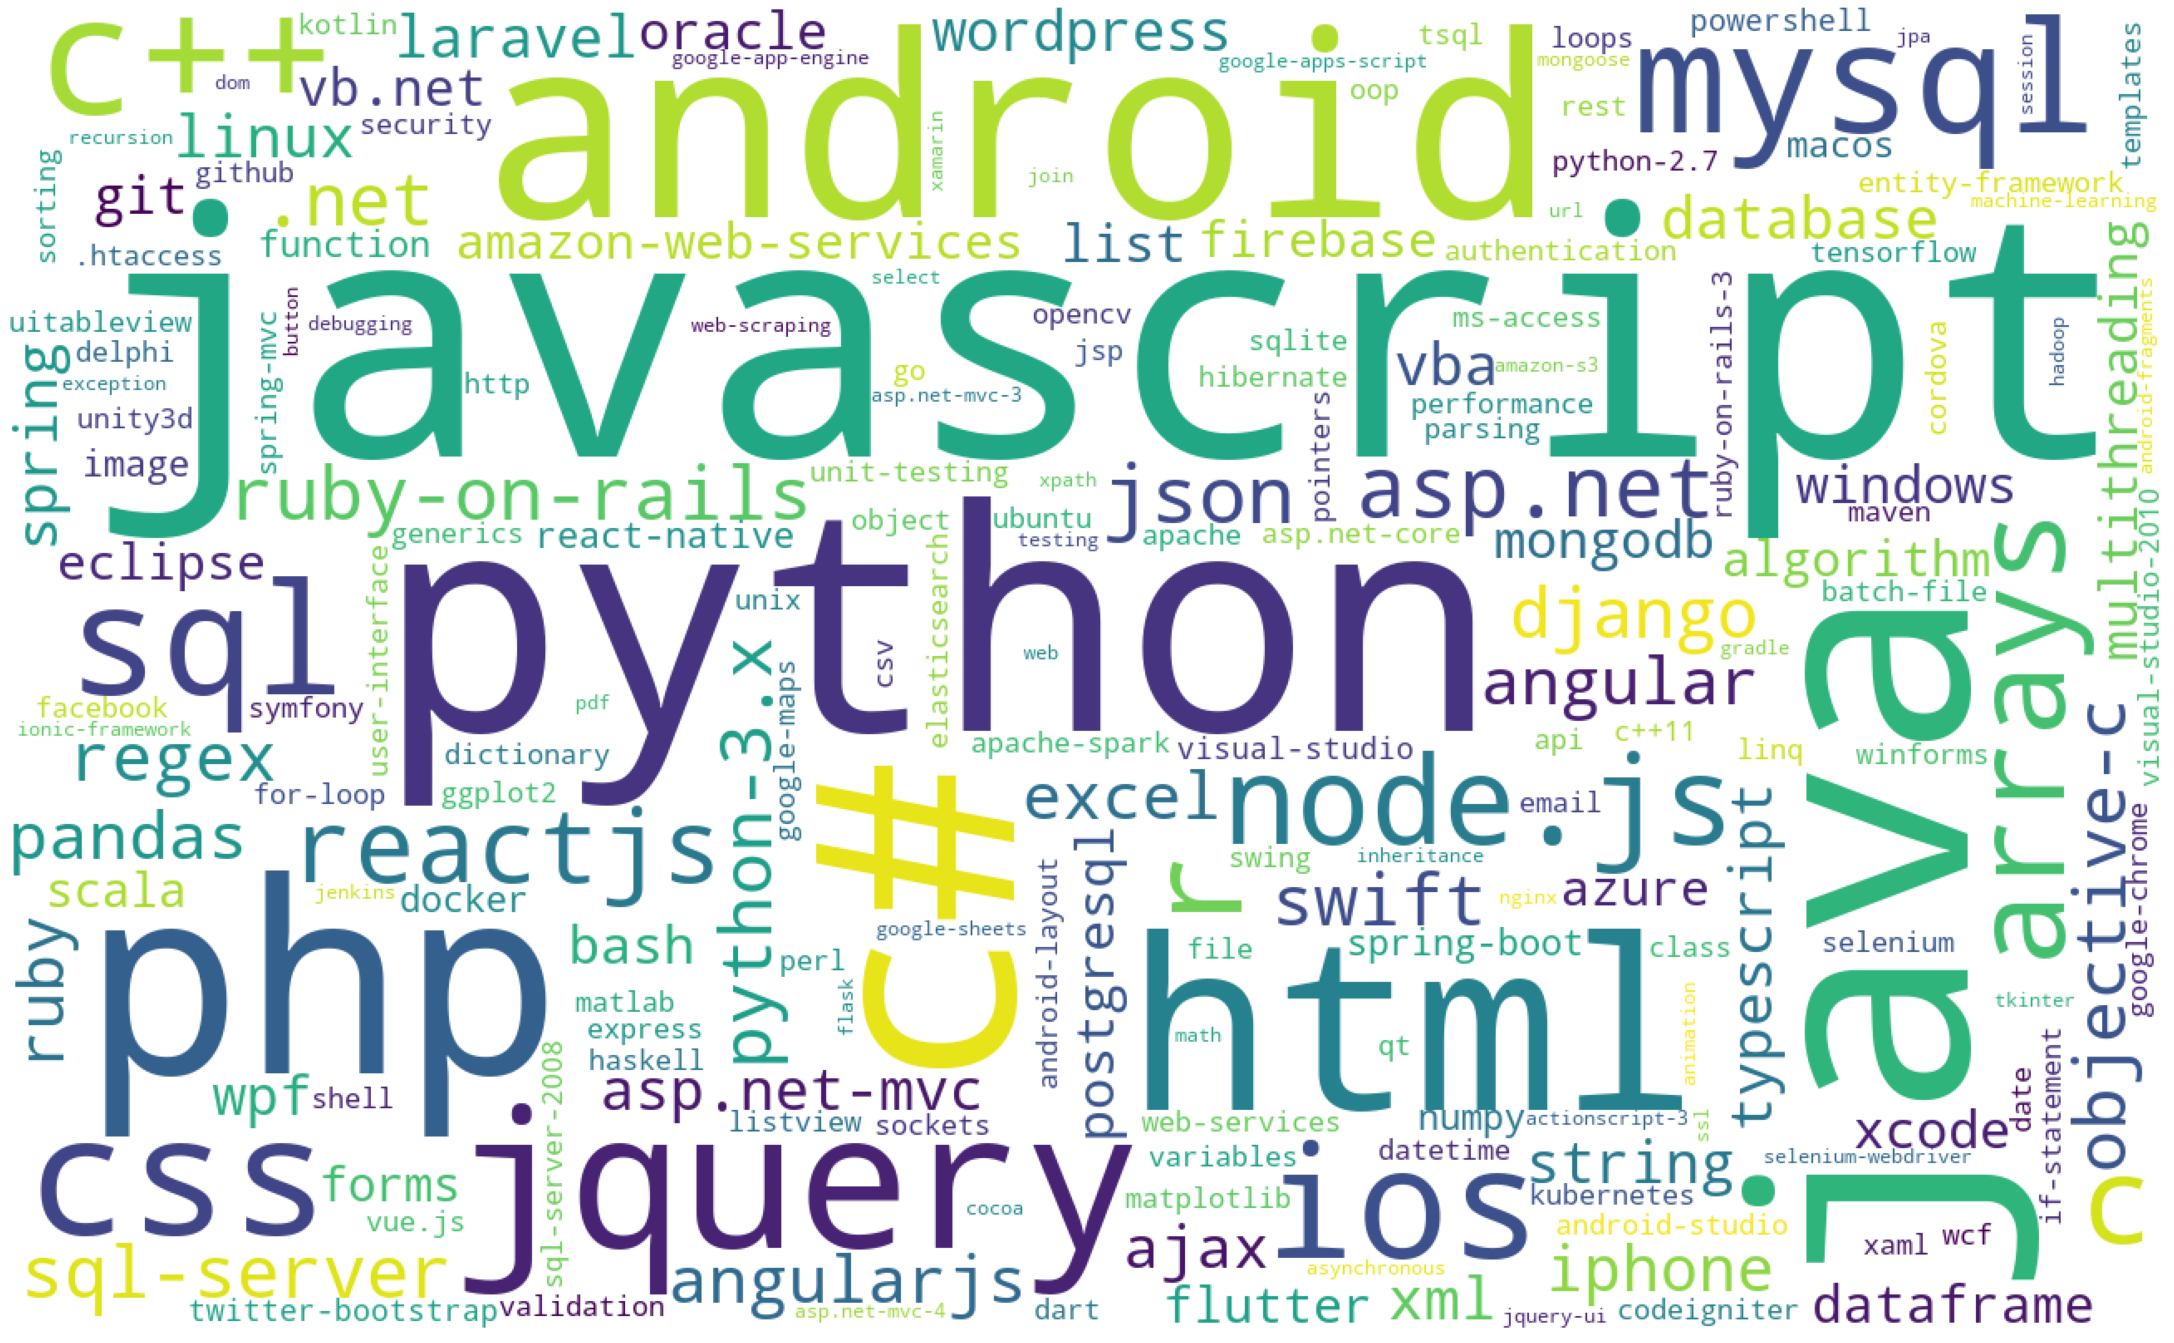

In [38]:
dict_tag_freq = dict(zip(df.tag, df.tag_count))
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='white',
                          width=1300,
                          height=800,
                    ).generate_from_frequencies(dict_tag_freq)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

<h4>8.1.2 Distribution plot of tags:

In [39]:
tag_counts = list(df['tag_count'].values)

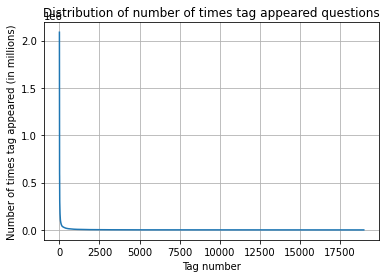

In [51]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared (in millions)")
plt.show()

<h4>500 Most commonly used tags:</h4>

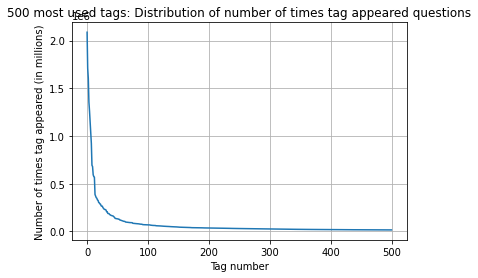

In [50]:
plt.plot(tag_counts[0:500])
plt.title('500 most used tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared (in millions)")
plt.show()

<h4>50 Most commonly used tags:</h4>

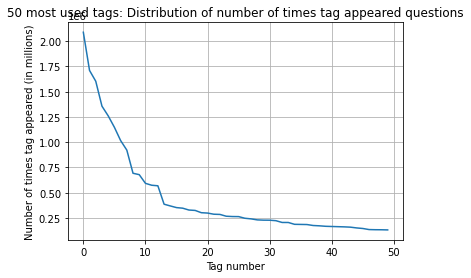

In [49]:
plt.plot(tag_counts[0:50])
plt.title('50 most used tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared (in millions)")
plt.show()

**Observations:**
1. Around 6 tags are used more than 1 million times.
2. Around 12 tags are used more than .5 million times.

<h4>10 Most commonly used tags:</h4>

In [42]:
df_10 = df.head(10)
df_10

,tag,tag_count
0,javascript,2088119
1,python,1710021
2,java,1603268
3,c#,1356602
4,php,1261172
5,android,1147994
6,html,1016815
7,jquery,921977
8,css,692783
9,c++,679053


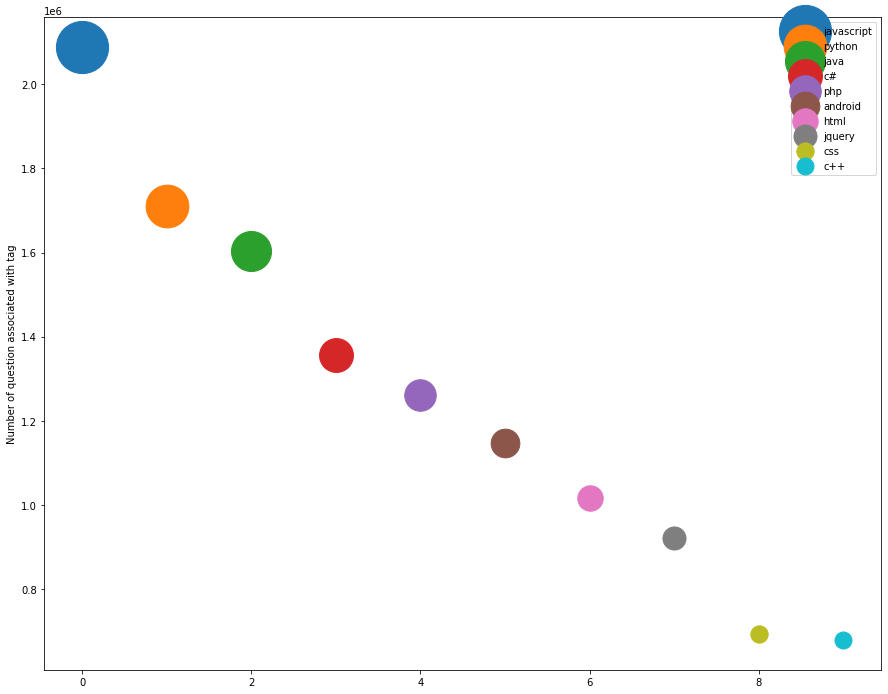

In [ ]:
x = list(df_10['tag'].values)
y = list(df_10['tag_count'].values)

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

area = [i/40000 for i in list(y)]   # 0 to 15 point radiuses
plt.figure(figsize=(15,12))
plt.ylabel("Number of questions associated with tag")
for i in range(len(y)):
    plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

plt.legend(numpoints=1)
plt.show()

**Observtions:**
1. Javascript is the most commonly used tag followed by python then java.
2. Javascript tag is used more than 2 million times.
3. Python tag is used 1.7 million times while java is used around 1.6 million times.
